# Vision Transformer Implementation and Training on CIFAR 10 dataset
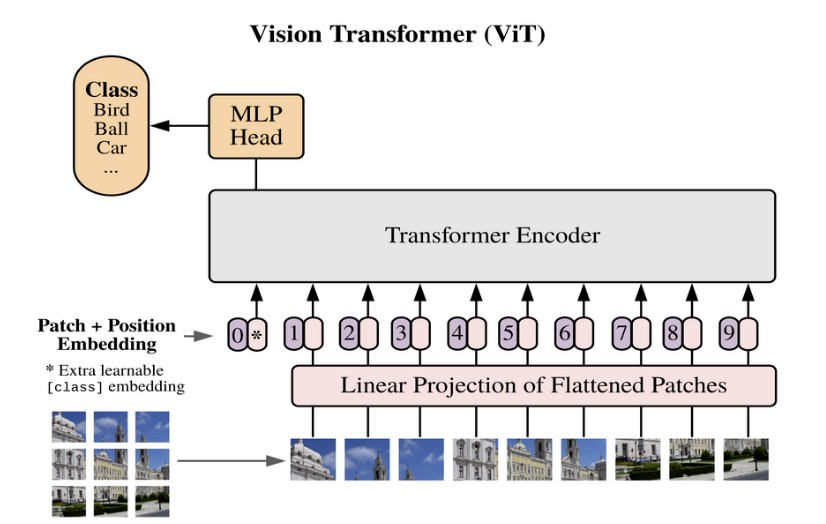

In [1]:
!pip install -q tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 5.5 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [3]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='') # TPU detection
except ValueError: # If TPU not found
  tpu = None

In [4]:
(x_train , y_train) , (x_test , y_test) =  keras.datasets.cifar10.load_data()
print(f'x_train shape {x_train.shape} , y_train shape {y_train.shape} ') # 50,000 samples
print(f'x_test shape {x_test.shape} , y_test shape {y_test.shape} ') # 10,000 samples

170498071/170498071 [==============================] - 4s 0us/step
x_train shape (50000, 32, 32, 3) , y_train shape (50000, 1) 
x_test shape (10000, 32, 32, 3) , y_test shape (10000, 1) 


In [5]:
# Hyper-Parameters #
# ===================== #
num_classes = 10
input_shape = (32 , 32 ,3 ) # h ,w ,c
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
n_epochs = 70
n_patches = 144
image_size = 72 # resize the input image
patch_size = 6 # Size of the patches to be extracted from input images
num_heads = 8 # attention heads
projection_dim  = 64 # ideally 256
transformer_units = [ # represents transformer lyaer in terms of dimensions
    projection_dim*2 ,
    projection_dim
]
transformer_layers = 8 # 8 encoders and 8 decoders
mlp_head_units = [2048 , 1024] #size of dense layers of the classifier


# ====================== #

In [6]:
def mlp(x , hidden_units , dropout_rate) :
    for unit in hidden_units :
        x = layers.Dense(units = unit , activation = tf.nn.gelu)(x)
        # GeLU - Gaussian Error Linear Unit || GeLU does well in nlp but is computationally costly
        x = layers.Dropout(dropout_rate)(x)
    return x

In [15]:
class CreatePatches(layers.Layer):
    def __init__(self , patch_size ) :
        super(CreatePatches , self ).__init__()
        self.patch_size = patch_size

    def call(self , inputs):
        batch_size = tf.shape(inputs)[0]
        patches = tf.image.extract_patches(
            images = inputs , # input images
            sizes = [1 , self.patch_size , self.patch_size ,1 ] ,
            strides =  [1 , self.patch_size , self.patch_size ,1 ] ,
            rates = [1,1,1,1] , # 1 means no dilation
            padding = 'VALID' # if the shapes is short pad the patches
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches , [batch_size , -1 , patch_dims] )
        return patches


Image Size 72 x 72
Patch Size 6 x 6
No. of Patches per Image 144
Elements in 1 Patch 108


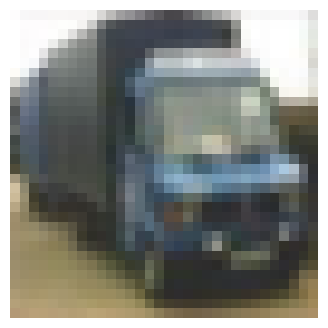

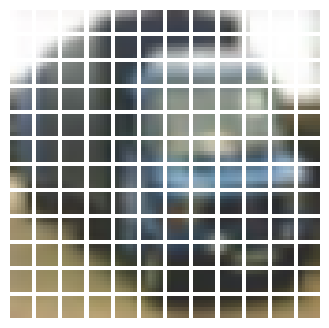

In [8]:
# Visualizing the patches
plt.figure(figsize = (4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
            tf.convert_to_tensor([image]) , size=(image_size , image_size)
)
patches = CreatePatches(patch_size = patch_size )(resized_image)
print(f'Image Size {image_size} x {image_size}')
print(f'Patch Size {patch_size} x {patch_size}')
print(f'No. of Patches per Image {patches.shape[1]}')
print(f'Elements in 1 Patch {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i , patch in enumerate(patches[0]) :
    ax = plt.subplot(n , n ,  i+1)
    patch_img = tf.reshape(patch , (patch_size , patch_size ,3 ))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

In [9]:
class PatchEncoder(layers.Layer) :
    def __init__(self , n_patches , projection_dim ) :
        super(PatchEncoder , self ).__init__()
        self.n_patches = n_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units = self.projection_dim)
        self.embedding = layers.Embedding(input_dim = self.n_patches ,
                                         output_dim = self.projection_dim)

    def call(self , patch ):
        position = tf.range(0 , self.n_patches , delta = 1 )
        encoded  =  self.projection(patch) + self.embedding(position)
        return encoded

In [10]:
def create_ViT_Classifier():
    data_augmentation = keras.Sequential(
                        [
                            layers.Normalization(), # (x - mean(x)) / var(x)
                            layers.Resizing(image_size , image_size)  ,
                            layers.RandomFlip('horizontal') ,
                            layers.RandomRotation(factor=0.02) ,
                            layers.RandomZoom(height_factor=0.2,width_factor=0.2)
                        ],
                        name = 'data_augmenter'
                    )
    data_augmentation.layers[0].adapt(x_train)
    inputs = layers.Input(shape = input_shape )
    augmented_data = data_augmentation(inputs) # augmentation
    patches = CreatePatches(patch_size)(augmented_data)
    encoded = PatchEncoder(n_patches  , projection_dim )(patches)

    # create multiples layers of transformer block
    for _ in range(transformer_layers) :
        # layer normalization
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded)
        attention_output = layers.MultiHeadAttention( # self attention
                    num_heads = num_heads ,
                    key_dim = projection_dim ,
                    dropout = 0.1
        )(x1,x1)
        # Skip Connection 1
        x2 = layers.Add()([attention_output , encoded])
        x3 = layers.LayerNormalization(epsilon=1e-6) (x2)
        # MLP
        x3 = mlp(x3 , transformer_units , 0.1  )
        enocoded = layers.Add()([x3 , x2] )

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation , mlp_head_units , 0.5 )
    # Classify
    logits = layers.Dense(num_classes )(features)

    model = keras.Model(inputs=inputs , outputs= logits)
    return model

In [11]:
def run_experiment():
    model = create_ViT_Classifier()
    print(model.summary())
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate ,
                                    weight_decay = weight_decay)

    model.compile(optimizer ,
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy', keras.metrics.SparseTopKCategoricalAccuracy(5 , name="Top5Accuracy")] )
    history = model.fit(x = x_train , y = y_train ,
                       batch_size = batch_size ,
                       epochs = n_epochs ,
                       validation_split=0.1 ,
                       )
    _ , accuracy , top5accuracy = model.evaluate(x_test ,y_test)
    print(f'Test Accuracy  : {round(accuracy * 100 , 2)} %' )
    print(f'Top 5 Test Accuracy  : {round(top5accuracy * 100 , 2)} %')

    return history , model


In [12]:
history , ViT = run_experiment()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_augmenter (Sequential  (None, 72, 72, 3)         7         
 )                                                               
                                                                 
 create_patches_1 (CreatePa  (None, None, 108)         0         
 tches)                                                          
                                                                 
 patch_encoder (PatchEncode  (None, 144, 64)           16192     
 r)                                                              
                                                                 
 layer_normalization_16 (La  (None, 144, 64)           128       
 yerNormalization)                                           

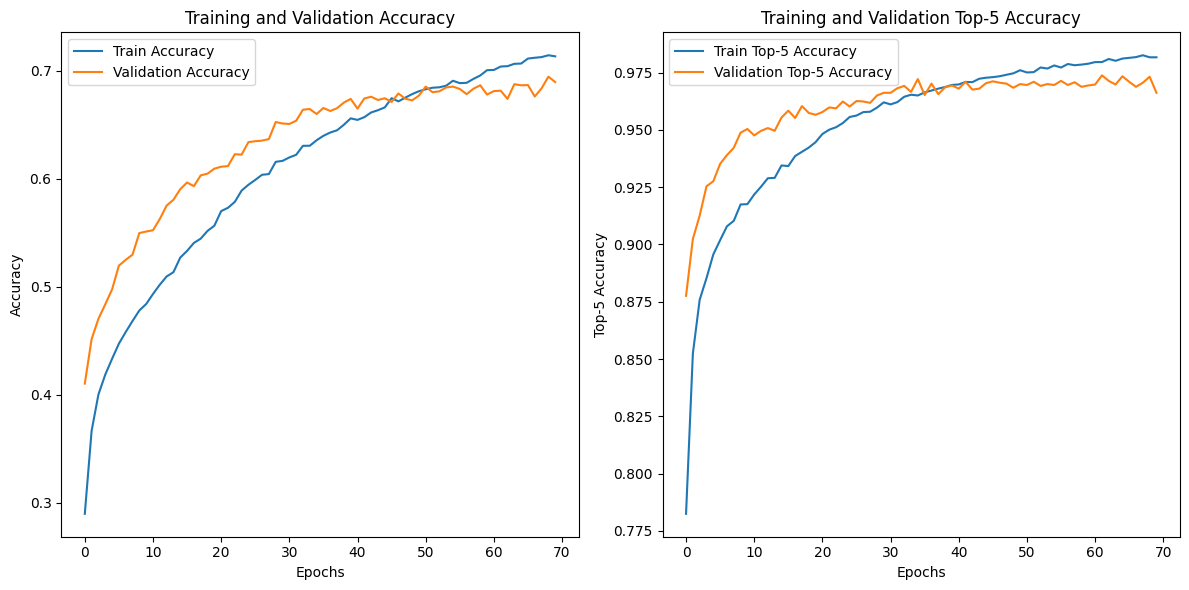

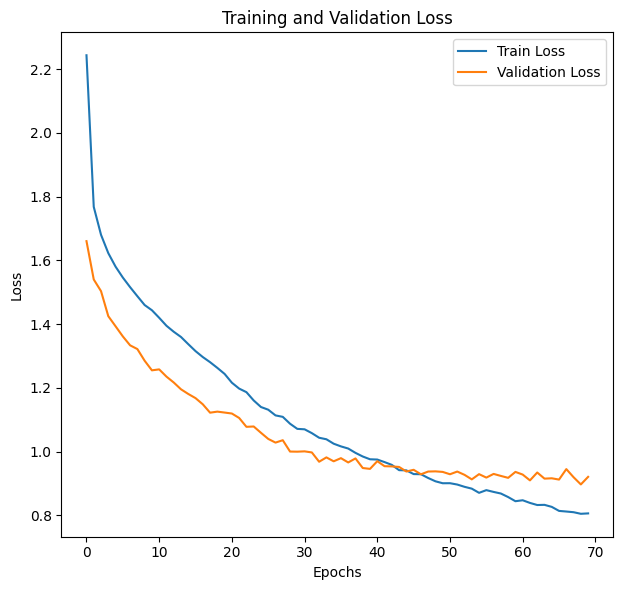

In [13]:

def plot_metrics(history):
    # Plotting accuracy and top-5 accuracy
    plt.figure(figsize=(12, 6))

    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Top-5 Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['Top5Accuracy'], label='Train Top-5 Accuracy')
    plt.plot(history.history['val_Top5Accuracy'], label='Validation Top-5 Accuracy')
    plt.title('Training and Validation Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotting loss
    plt.figure(figsize=(12, 6))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming `history` is the history object from model training
# Replace `history` with your actual history object
plot_metrics(history)


In [16]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [17]:
def predict_img(images , model):
  if len(image.shape) == 3 :
    pred = model.predict(images.reshape(-1,*images.shape))
  else :
    pred = model.predict(images)
  pred = np.argmax(pred , axis=1)
  return [class_names[x] for x in pred]

1/1 [==============================] - 0s 250ms/step
Prediction : dog


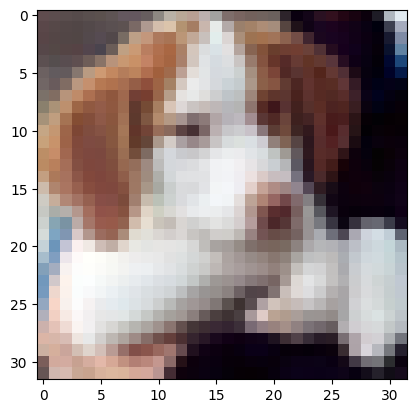

In [18]:
index = 16
plt.imshow(x_test[16])
prediction = predict_img(x_test[16] , ViT)
print(f"Prediction : {prediction[0]}")

In [19]:
y_pred = model.predict(x_test)

313/313 [==============================] - 1s 4ms/step


In [22]:
y_pred = np.argmax(y_pred , axis=1)
y_pred.shape

(10000,)

In [23]:
y_test.shape

(10000, 1)

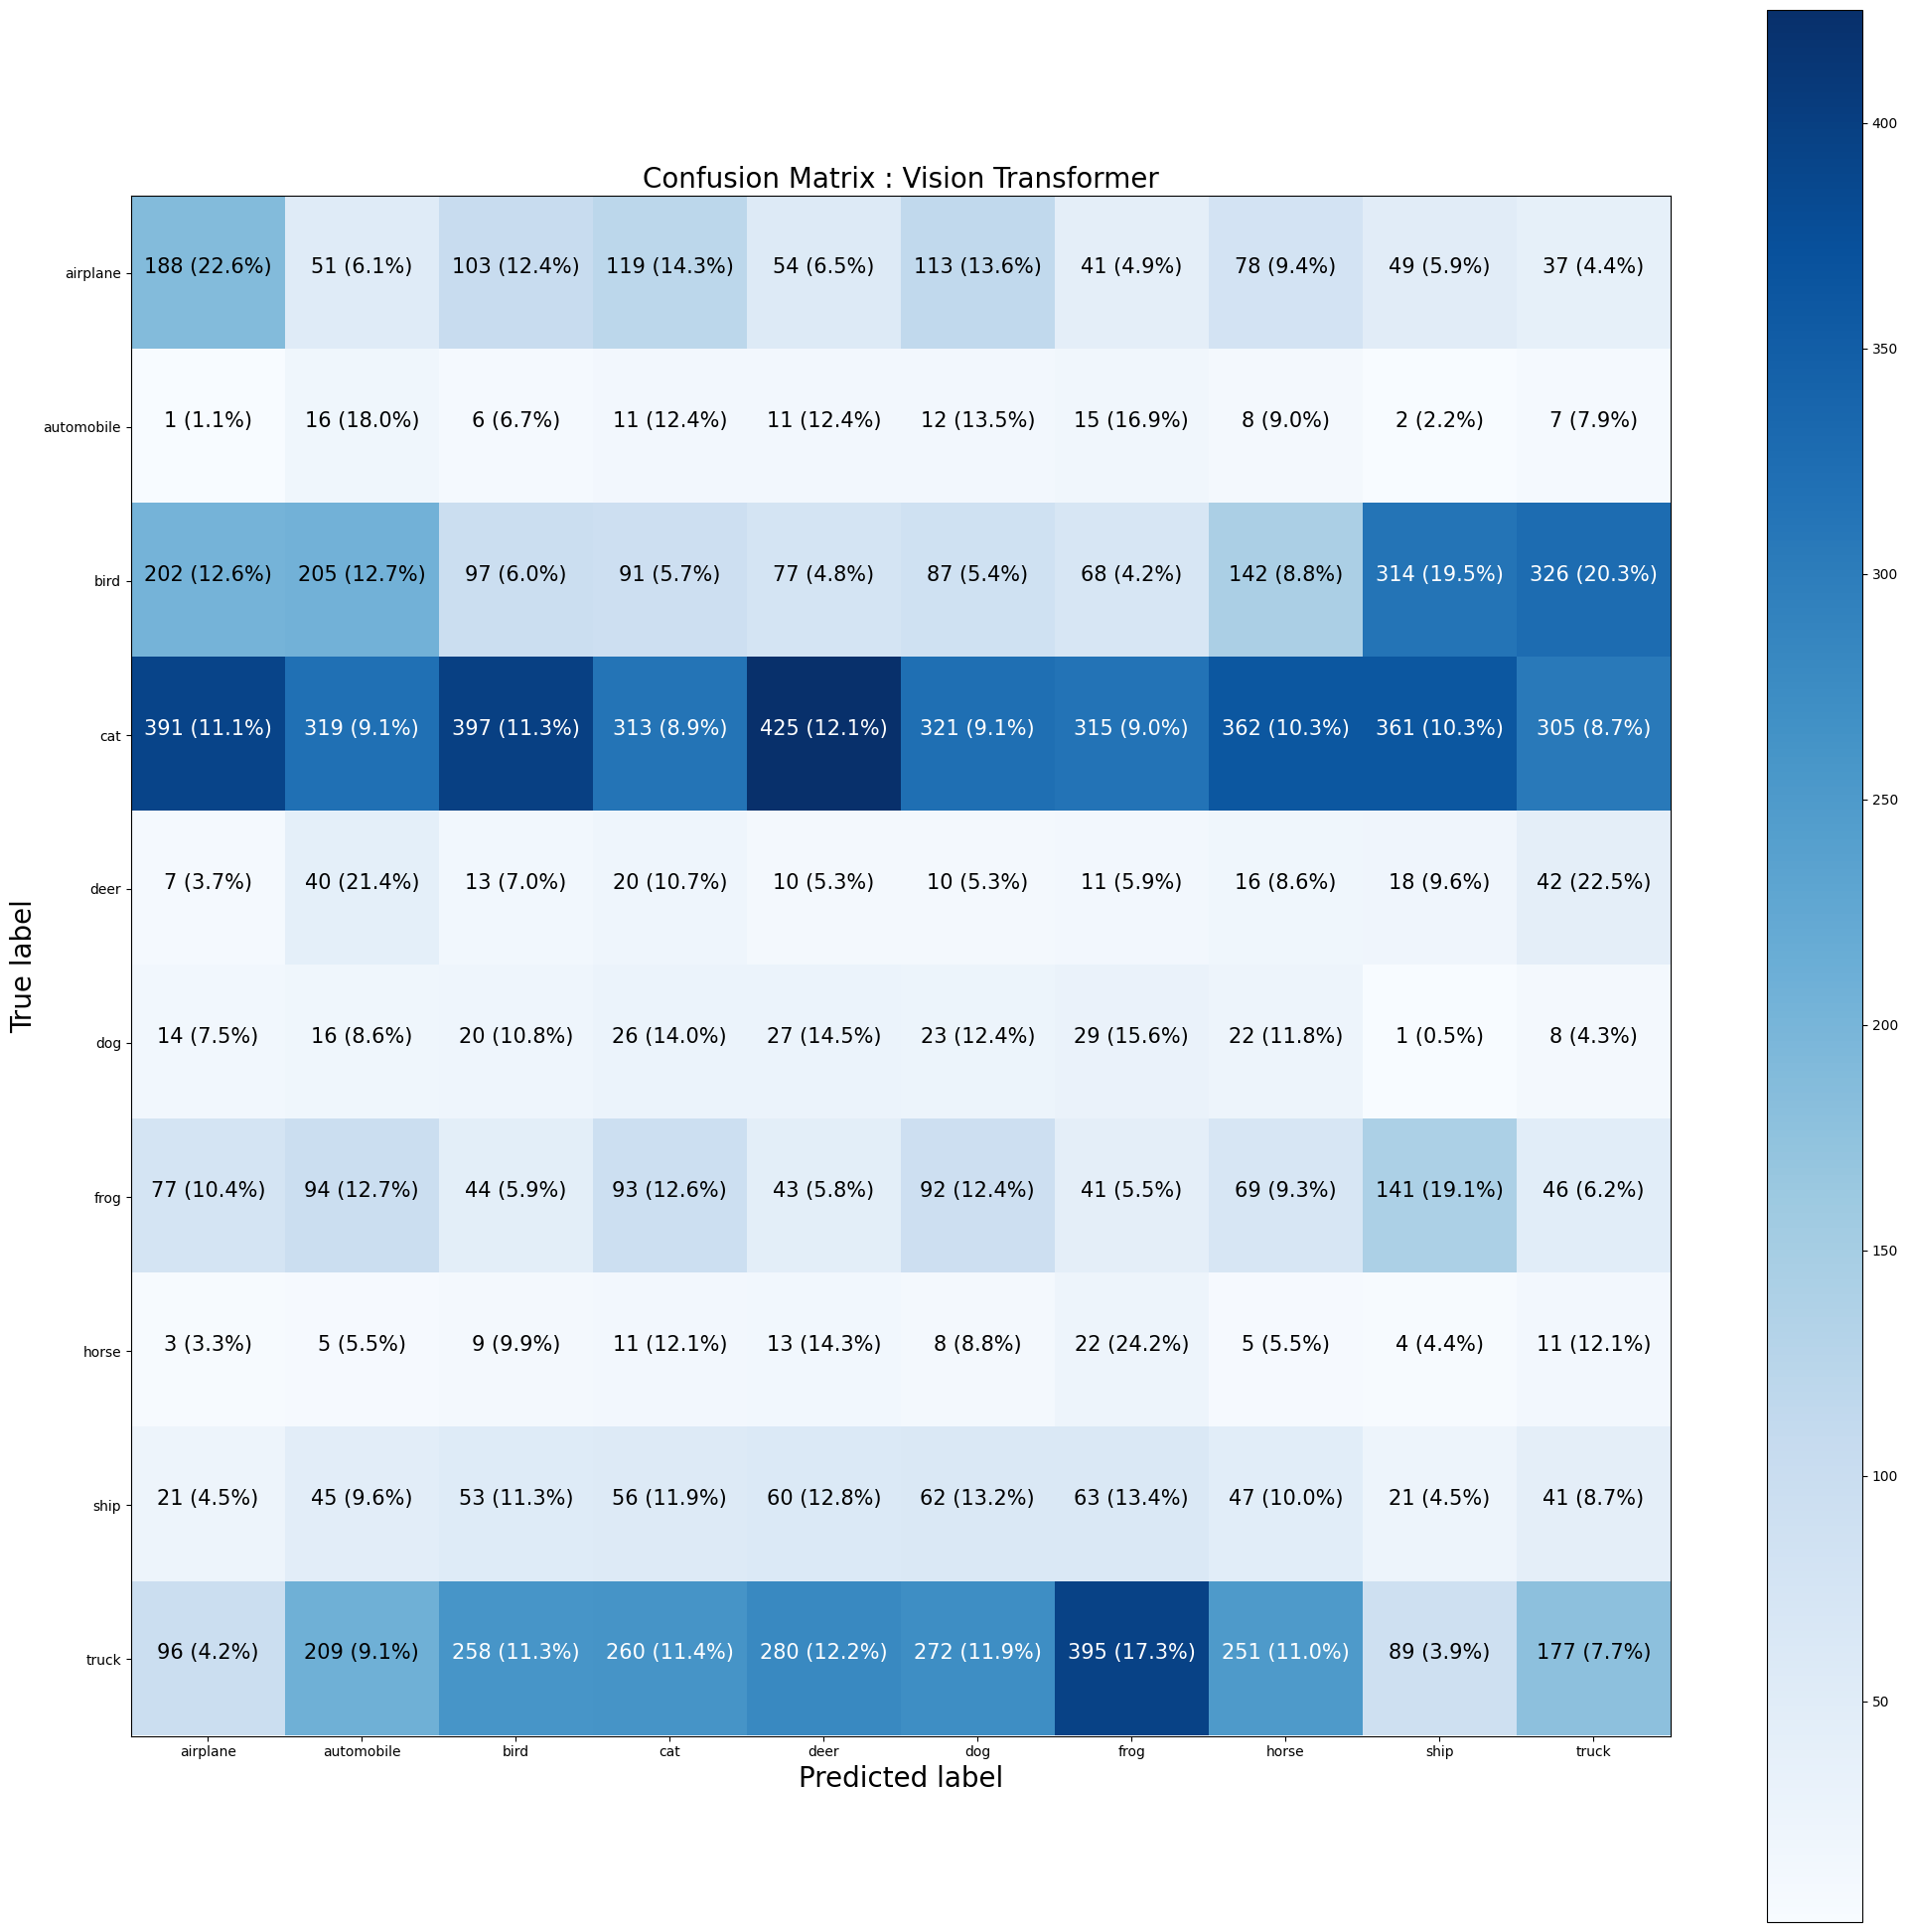

In [27]:

from sklearn.metrics import confusion_matrix
import itertools


figsize = (25, 25)

# Create the confusion matrix
cm = confusion_matrix(y_pred , y_test)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = True

if classes:
  labels = class_names
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix : Vision Transformer",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)
plt.grid(False)
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)


---